In [1]:
import os
import time
from ROOT import *

def add_parent_lib_path(name="Pheno_BSM"):
    import sys
    sys.path.append(
        os.path.join(
            sys.path[0].split(name)[0],name
        )
    )
add_parent_lib_path()

from ml_tools import Log_Reg_Classifier
from ml_tools import XGB_Classifier

Welcome to JupyROOT 6.22/06


/Collider/ROOT/installROOT/lib/ROOT/_facade.py:121: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return _orig_ihook(name, *args, **kwds)
/usr/local/lib64/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def get_signal_names(mass):
    if mass < 1000:
        name=f"LQ_LQ_0{mass}_wo_RHC"
        name2=f"Tau_LQ_0{mass}_wo_RHC"
    else :
        name=f"LQ_LQ_{mass}_wo_RHC"
        name2=f"Tau_LQ_{mass}_wo_RHC"
    signal_names=[name, name2]

    return signal_names
def get_features_by_channel(channel):
    part_dict={
        "b_tau_tau_hadronic":[
            "b_{1}",
            "#tau_{1}",
            "#tau_{2}"
            ],
        "b_b_tau_tau_hadronic" :[
            "b_{1}",
            "b_{2}",
            "#tau_{1}",
            "#tau_{2}"
            ],
        "b_tau_tau_semileptonic" :[
            "b_{1}",
            "#tau_{1}",
            "lep_{1}"
            ],
        "b_b_tau_tau_semileptonic" :[
            "b_{1}",
            "b_{2}",
            "#tau_{1}",
            "lep_{1}"
            ]
    }
    key=channel
    n_Tod=len(part_dict[key])
    lep_a=part_dict[key][n_Tod-2]
    lep_b=part_dict[key][n_Tod-1]

    co_particles=part_dict[key].copy()
    features=[
        'MET(GeV)',
        '#phi_{MET}',
        f"Q_{{{lep_a}}}Q_{{{lep_b}}}",
        'light_jets_multiplicity',
        #'mT(GeV)',
        'sT(GeV)',
    ]
    for particle in part_dict[key]:
        features+=[
            f'Energy_{{{particle}}}(GeV)',
            f'pT_{{{particle}}}(GeV)',
            f'#phi_{{{particle}}}',
            f'#eta_{{{particle}}}'
        ]
        co_particles.pop(0)
        for co_particle in co_particles:
            features+=[f"#Delta R_{{{particle}{co_particle}}}"]
            features+=[f"#Delta #eta_{{{particle}{co_particle}}}"]
            features+=[f"#Delta #phi_{{{particle}{co_particle}}}"]
            features+=[f"#Delta pT_{{{particle}{co_particle}}}(GeV)"]
            features+=[f"#Delta #vec{{pT}}_{{{particle}{co_particle}}}(GeV)"]
            features+=[f"#Delta #vec{{p}}_{{{particle}{co_particle}}}(GeV)"]
            
    return features

In [3]:
folder_out=os.path.join(
    os.path.dirname(os.getcwd()),
    "03_delphes_preselection"
)
csv_files_path=os.path.join(folder_out,"Selected_Events")

masses=list(range(1000,2500+1,250))
test_parameters={
    "n_estimators":[
        250,
        500,
        750,
        1000
    ],
    "max_depth":[
        3,
        5,
        7,
        9
    ],
    "learning_rate":[
        0.1
    ]
}

bkgs=[
        "ttbar",
        "stop",
        "w_jets",
        "z_jets",
        "ww",
        "wz",
        "zz"
    ]

In [4]:
mass=1500
channel="b_tau_tau_hadronic"
signals=get_signal_names(mass)
feats=get_features_by_channel(channel)
feats.sort()
xbg_class=XGB_Classifier(
    features=feats,
    channels=[channel],
    csv_files_path=csv_files_path,
    bkg_names=bkgs,
    signal_names=signals,
    parameters=test_parameters
)
df=xbg_class.get_features_corr()

<AxesSubplot:>

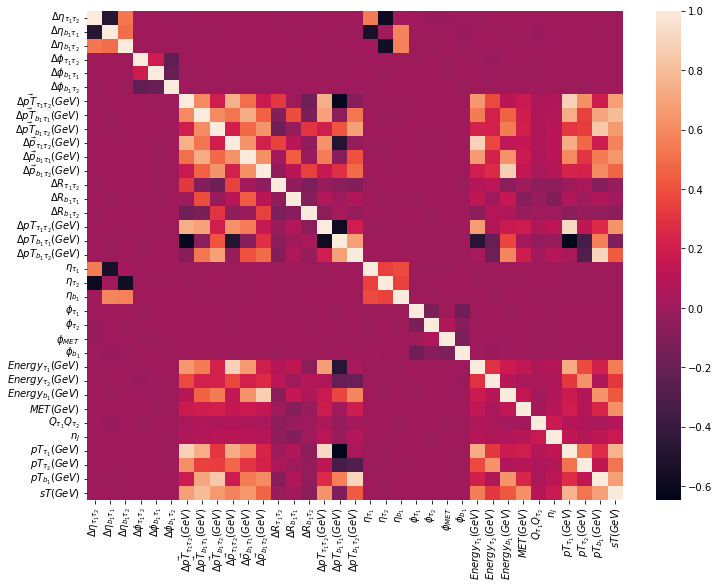

In [5]:
import seaborn as sns
from matplotlib import pyplot
pyplot.figure(figsize=(12, 9))#inches
sns.heatmap(df, xticklabels=True, yticklabels=True)

In [6]:
start_time = time.time()
xbg_class.fit_model()
elapsed=(time.time() - start_time)/3600.
print(f"done! time elapsed: {elapsed} hours.")
xbg_class.model.fpr(xbg_class.testLab,preds=xbg_class.testPred)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:22:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_1500_wo_RHC', 'Tau_LQ_1500_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 250}
[17:22:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.999885898478171
the test accuracy is 0.9871210356417851
the most important variables are
                                          0         1
0                                   sT(GeV)  0.860337
1                  Q_{#tau_{1}}Q_{#tau_{2}}  0.014802
2                           pT_{b_{1}}(GeV)  0.006315
3                  #Delta

0.012724501292332163

/usr/local/lib64/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib64/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib64/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1)

In [7]:
ask="$"+xbg_class.importances_df[0][0].replace("#","\\")+"$"
corr_var=[]
for key in df[ask].keys():
    if key == ask: continue
    elif abs(df[ask][key]) >=0.60 :
        featkey=key.replace("\\","#").removesuffix("$").removeprefix("$")
        corr_var+=[featkey]
        print(featkey, df[ask][key])

#Delta #vec{pT}_{#tau_{1}#tau_{2}}(GeV) 0.6753527510353821
#Delta #vec{pT}_{b_{1}#tau_{1}}(GeV) 0.7919327750770775
#Delta #vec{pT}_{b_{1}#tau_{2}}(GeV) 0.6560335730975964
#Delta #vec{p}_{b_{1}#tau_{1}}(GeV) 0.6420744647278329
#Delta pT_{#tau_{1}#tau_{2}}(GeV) 0.6356042499850418
MET(GeV) 0.6234419578499558
pT_{#tau_{1}}(GeV) 0.7587890612191068
pT_{b_{1}}(GeV) 0.6774214611773358


In [8]:
important_feats=[]
for important in list(xbg_class.importances_df[0]):
    ask="$"+important.replace("#","\\")+"$"
    if ask == '$light_jets_multiplicity$':continue
    corr_var=[]
    for key in df[ask].keys():
        if key == ask: continue
        elif abs(df[ask][key]) >=0.60 :
            featkey=key.replace("\\","#").removesuffix("$").removeprefix("$")
            corr_var+=[featkey]
            #print(featkey, df[ask][key])
    for j, feat in enumerate(feats):
        if len(feats) < 10: continue
        if (feat in corr_var) and not(feat in important_feats):
            feats.pop(j)
    if (important in feats) and not (len(important_feats)>=10):
        important_feats+=[important]
important_feats

['sT(GeV)',
 'Q_{#tau_{1}}Q_{#tau_{2}}',
 '#Delta R_{b_{1}#tau_{1}}',
 '#Delta #eta_{b_{1}#tau_{1}}',
 '#Delta R_{b_{1}#tau_{2}}',
 '#Delta R_{#tau_{1}#tau_{2}}',
 '#Delta #eta_{b_{1}#tau_{2}}',
 '#Delta #eta_{#tau_{1}#tau_{2}}',
 '#Delta #phi_{b_{1}#tau_{1}}',
 'Energy_{#tau_{2}}(GeV)']

In [9]:
xbg_class=XGB_Classifier(
    features=important_feats,
    channels=[channel],
    csv_files_path=csv_files_path,
    bkg_names=bkgs,
    signal_names=signals,
    parameters=test_parameters
)
df=xbg_class.get_features_corr()

<AxesSubplot:>

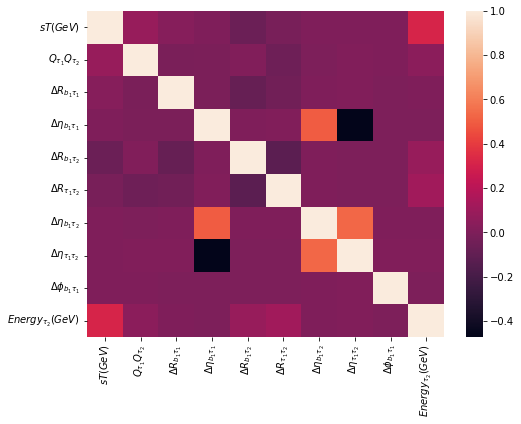

In [10]:
import seaborn as sns
from matplotlib import pyplot
pyplot.figure(figsize=(8, 6))#inches
sns.heatmap(df, xticklabels=True, yticklabels=True)

In [11]:
start_time = time.time()
xbg_class.fit_model()
elapsed=(time.time() - start_time)/3600.
print(f"done! time elapsed: {elapsed} hours.")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:39:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_1500_wo_RHC', 'Tau_LQ_1500_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
[17:39:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.988290331322294
the test accuracy is 0.9846583912942194
the most important variables are
                                0         1
0                         sT(GeV)  0.910298
1        Q_{#tau_{1}}Q_{#tau_{2}}  0.024407
2     #Delta #eta_{b_{1}#tau_{1}}  0.011902
3          Energy_{#tau_{2}}(GeV)  0.009383
4     #Delta #phi_{b_

In [12]:
xbg_class.model.fpr(xbg_class.testLab,preds=xbg_class.testPred)

0.01446350487722839

In [13]:
images_folder=os.path.join(f"MLQ_{mass}",f"{channel}")
os.system(f"mkdir -p '{images_folder}'")
xbg_class.get_discriminator_histograms(images_folder)

{'LQ_LQ_1500_wo_RHC': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x56264afaaed0>},
 'Tau_LQ_1500_wo_RHC': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x56264806d000>},
 'ttbar': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x562647f81be0>},
 'stop': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x5626460ea8c0>},
 'w_jets': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x56264b3f2660>},
 'z_jets': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x56264625dca0>},
 'ww': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x56264b3f4d80>},
 'wz': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x5626460eacb0>},
 'zz': {'b_tau_tau_hadronic': <cppyy.gbl.TH1F object at 0x5626481fef30>}}

Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_LQ_LQ_1500_wo_RHC.png has been created
Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_Tau_LQ_1500_wo_RHC.png has been created
Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_ttbar.png has been created
Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_stop.png has been created
Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_w_jets.png has been created
Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_z_jets.png has been created
Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_ww.png has been created
Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_wz.png has been created
Info in <TCanvas::Print>: png file MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting_zz.png has been created


In [14]:
def get_important_features(channel):
    mass=1500
    signals=get_signal_names(mass)
    feats=get_features_by_channel(channel)
    feats.sort()
    xbg_class=XGB_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals,
        parameters=test_parameters
    )
    df=xbg_class.get_features_corr()
    xbg_class.fit_model()
    important_feats=[]
    for important in list(xbg_class.importances_df[0]):
        ask="$"+important.replace("#","\\")+"$"
        if ask == '$light_jets_multiplicity$':continue
        corr_var=[]
        for key in df[ask].keys():
            if key == ask: continue
            elif abs(df[ask][key]) >=0.60 :
                featkey=key.replace("\\","#").removesuffix("$").removeprefix("$")
                corr_var+=[featkey]
                #print(featkey, df[ask][key])
        for j, feat in enumerate(feats):
            if len(feats) < 10: continue
            if (feat in corr_var) and not(feat in important_feats):
                feats.pop(j)
        if (important in feats) and not (len(important_feats)>=10):
            important_feats+=[important]
    return important_feats

In [15]:
channel="b_tau_tau_hadronic"
feats=get_important_features(channel)
def doit(mass):
    start_time = time.time()
    signals=get_signal_names(mass)
    xbg_class=XGB_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals,
        parameters=test_parameters,
        cv=5
    )
    log_reg_class=Log_Reg_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals
    )
    xbg_class.fit_model()
    log_reg_class.fit_model()
    images_folder=os.path.join(f"MLQ_{mass}",f"{channel}")
    os.system(f"rm -rf '{images_folder}'")
    os.system(f"mkdir -p '{images_folder}'")
    log_reg_histos=log_reg_class.get_discriminator_histograms(images_folder)
    xbg_histos=xbg_class.get_discriminator_histograms(images_folder)
    elapsed=(time.time() - start_time)/3600.
    print(f"{mass} done! time elapsed: {elapsed} hours.")
    return f"Done {mass}", mass
dict(map(doit,masses))
print(csv_files_path)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:19:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_1500_wo_RHC', 'Tau_LQ_1500_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}
[18:20:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.9948939568981501
the test accuracy is 0.9858231555126626
the most important variables are
                                          0         1
0                                   sT(GeV)  0.854868
1                  Q_{#tau_{1}}Q_{#tau_{2}}  0.012568
2                  #Delta R_{b_{1}#tau_{1}}  0.007361
3               #Delta #

/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:37:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_1000_wo_RHC', 'Tau_LQ_1000_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
[18:37:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.9745553606321224
the test accuracy is 0.9719791008020233
the most important variables are
                                        0         1
0                                 sT(GeV)  0.880789
1                Q_{#tau_{1}}Q_{#tau_{2}}  0.032736
2             #Delta #eta_{b_{1}#tau_{1}}  0.016943
3             #Delta #eta_{b_{1}

/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_1250_wo_RHC', 'Tau_LQ_1250_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
[18:55:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.9849385991185657
the test accuracy is 0.9803654031748145
the most important variables are
                                        0         1
0                                 sT(GeV)  0.892709
1                Q_{#tau_{1}}Q_{#tau_{2}}  0.036841
2             #Delta #eta_{b_{1}#tau_{1}}  0.012937
3  #Delta #vec{p}_{#tau_{1}#tau_

/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:12:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_1500_wo_RHC', 'Tau_LQ_1500_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
[19:12:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.9874488325988048
the test accuracy is 0.9845252753835402
the most important variables are
                                        0         1
0                                 sT(GeV)  0.904095
1                Q_{#tau_{1}}Q_{#tau_{2}}  0.026968
2             #Delta #eta_{b_{1}#tau_{1}}  0.014751
3  #Delta #vec{p}_{#tau_{1}#tau_

/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:28:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_1750_wo_RHC', 'Tau_LQ_1750_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
[19:28:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.9912284455093919
the test accuracy is 0.9869879197311059
the most important variables are
                                        0         1
0                                 sT(GeV)  0.927630
1                Q_{#tau_{1}}Q_{#tau_{2}}  0.020040
2                #Delta R_{b_{1}#tau_{1}}  0.008241
3             #Delta #eta_{b_{1}

/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:44:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_2000_wo_RHC', 'Tau_LQ_2000_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 250}
[19:45:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.9989160355426241
the test accuracy is 0.9896169589670205
the most important variables are
                                        0         1
0                                 sT(GeV)  0.926229
1                Q_{#tau_{1}}Q_{#tau_{2}}  0.018275
2                #Delta R_{b_{1}#tau_{1}}  0.009302
3             #Delta #eta_{b_{1}

/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:00:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_2250_wo_RHC', 'Tau_LQ_2250_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
[20:00:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.993581789397116
the test accuracy is 0.9917135345602183
the most important variables are
                                        0         1
0                                 sT(GeV)  0.932640
1                Q_{#tau_{1}}Q_{#tau_{2}}  0.021183
2                #Delta R_{b_{1}#tau_{1}}  0.007460
3             #Delta #eta_{b_{1}#

/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:15:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_2500_wo_RHC', 'Tau_LQ_2500_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
[20:15:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.9949795330395219
the test accuracy is 0.9932443675330294
the most important variables are
                                        0         1
0                                 sT(GeV)  0.941630
1                Q_{#tau_{1}}Q_{#tau_{2}}  0.013860
2                #Delta R_{b_{1}#tau_{1}}  0.009166
3             #Delta #phi_{b_{1}

Info in <TCanvas::Print>: png file MLQ_1000/b_tau_tau_hadronic/Logistic_Regression_LQ_LQ_1000_wo_RHC.png has been created
Info in <TCanvas::Print>: png file MLQ_1000/b_tau_tau_hadronic/Logistic_Regression_Tau_LQ_1000_wo_RHC.png has been created
Info in <TCanvas::Print>: png file MLQ_1000/b_tau_tau_hadronic/Logistic_Regression_ttbar.png has been created
Info in <TCanvas::Print>: png file MLQ_1000/b_tau_tau_hadronic/Logistic_Regression_stop.png has been created
Info in <TCanvas::Print>: png file MLQ_1000/b_tau_tau_hadronic/Logistic_Regression_w_jets.png has been created
Info in <TCanvas::Print>: png file MLQ_1000/b_tau_tau_hadronic/Logistic_Regression_z_jets.png has been created
Info in <TCanvas::Print>: png file MLQ_1000/b_tau_tau_hadronic/Logistic_Regression_ww.png has been created
Info in <TCanvas::Print>: png file MLQ_1000/b_tau_tau_hadronic/Logistic_Regression_wz.png has been created
Info in <TCanvas::Print>: png file MLQ_1000/b_tau_tau_hadronic/Logistic_Regression_zz.png has been c

In [16]:
channel="b_tau_tau_semileptonic"
feats=get_important_features(channel)
def doit(mass):
    start_time = time.time()
    signals=get_signal_names(mass)
    xbg_class=XGB_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals,
        parameters=test_parameters,
        cv=5
    )
    log_reg_class=Log_Reg_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals
    )
    xbg_class.fit_model()
    log_reg_class.fit_model()
    images_folder=os.path.join(f"MLQ_{mass}",f"{channel}")
    os.system(f"rm -rf '{images_folder}'")
    os.system(f"mkdir -p '{images_folder}'")
    log_reg_histos=log_reg_class.get_discriminator_histograms(images_folder)
    xbg_histos=xbg_class.get_discriminator_histograms(images_folder)
    elapsed=(time.time() - start_time)/3600.
    print(f"{mass} done! time elapsed: {elapsed} hours.")
    return f"Done {mass}", mass
dict(map(doit,masses))
print(csv_files_path)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:21:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_1500_wo_RHC', 'Tau_LQ_1500_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000}
[21:26:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 1.0
the test accuracy is 0.9837910645389585
the most important variables are
                                         0         1
0                                  sT(GeV)  0.862619
1                  Q_{#tau_{1}}Q_{lep_{1}}  0.021088
2                                 MET(GeV)  0.006720
3               #Delta #eta_{b_{1}lep_{1}}

/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_1000_wo_RHC', 'Tau_LQ_1000_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}
[21:55:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.9748806643254592
the test accuracy is 0.9688495419696403
the most important variables are
                                       0         1
0                                sT(GeV)  0.865382
1                Q_{#tau_{1}}Q_{lep_{1}}  0.048423
2             #Delta #eta_{b_{1}lep_{1}}  0.017637
3            #Delta #eta_{b_{1}#tau_

/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:22:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_1250_wo_RHC', 'Tau_LQ_1250_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}
[22:23:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.9841513829350493
the test accuracy is 0.9774109470026064
the most important variables are
                                       0         1
0                                sT(GeV)  0.905421
1                Q_{#tau_{1}}Q_{lep_{1}}  0.027176
2             #Delta #eta_{b_{1}lep_{1}}  0.012484
3            #Delta #eta_{b_{1}#tau_

/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:49:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_1500_wo_RHC', 'Tau_LQ_1500_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
[22:49:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.9845313921747043
the test accuracy is 0.9841335068374312
the most important variables are
                                       0         1
0                                sT(GeV)  0.897332
1                Q_{#tau_{1}}Q_{lep_{1}}  0.030654
2             #Delta #eta_{b_{1}lep_{1}}  0.012004
3                        pT_{b_{1}}(

/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_1750_wo_RHC', 'Tau_LQ_1750_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
[23:14:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.9886723653535776
the test accuracy is 0.9870054395834302
the most important variables are
                                       0         1
0                                sT(GeV)  0.917520
1                Q_{#tau_{1}}Q_{lep_{1}}  0.018863
2             #Delta #eta_{b_{1}lep_{1}}  0.011649
3                #Delta R_{b_{1}lep_

/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:37:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_2000_wo_RHC', 'Tau_LQ_2000_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 750}
[23:37:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.993898388234212
the test accuracy is 0.9891255097417309
the most important variables are
                                       0         1
0                                sT(GeV)  0.931745
1                Q_{#tau_{1}}Q_{lep_{1}}  0.023472
2             #Delta #eta_{b_{1}lep_{1}}  0.007890
3                        pT_{b_{1}}(G

/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_2250_wo_RHC', 'Tau_LQ_2250_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}
[00:00:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.995344255495645
the test accuracy is 0.990854543694958
the most important variables are
                                       0         1
0                                sT(GeV)  0.938448
1                Q_{#tau_{1}}Q_{lep_{1}}  0.015389
2             #Delta #eta_{b_{1}lep_{1}}  0.007149
3            #Delta #eta_{b_{1}#tau_{1

/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_2500_wo_RHC', 'Tau_LQ_2500_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
[00:22:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.9952595748235392
the test accuracy is 0.992861667397554
the most important variables are
                                       0         1
0                                sT(GeV)  0.936079
1                Q_{#tau_{1}}Q_{lep_{1}}  0.019358
2             #Delta #eta_{b_{1}lep_{1}}  0.007590
3                        pT_{b_{1}}(G

/usr/local/lib64/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib64/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib64/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1)

In [17]:
channel="b_b_tau_tau_hadronic"
feats=get_important_features(channel)
def doit(mass):
    start_time = time.time()
    signals=get_signal_names(mass)
    xbg_class=XGB_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals,
        parameters=test_parameters,
        cv=5
    )
    log_reg_class=Log_Reg_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals
    )
    xbg_class.fit_model()
    log_reg_class.fit_model()
    images_folder=os.path.join(f"MLQ_{mass}",f"{channel}")
    os.system(f"rm -rf '{images_folder}'")
    os.system(f"mkdir -p '{images_folder}'")
    log_reg_histos=log_reg_class.get_discriminator_histograms(images_folder)
    xbg_histos=xbg_class.get_discriminator_histograms(images_folder)
    elapsed=(time.time() - start_time)/3600.
    print(f"{mass} done! time elapsed: {elapsed} hours.")
    return f"Done {mass}", mass
dict(map(doit,masses))
print(csv_files_path)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:37:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_1500_wo_RHC', 'Tau_LQ_1500_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}
[00:37:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 1.0
the test accuracy is 0.9891770670826833
the most important variables are
                                          0         1
0                                   sT(GeV)  0.794872
1                           pT_{b_{2}}(GeV)  0.010040
2                  Q_{#tau_{1}}Q_{#tau_{2}}  0.009425
3         #Delta #vec{pT}_{b_{1}b_{2}}(

/usr/local/lib64/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:43:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the ['LQ_LQ_1000_wo_RHC', 'Tau_LQ_1000_wo_RHC'] model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
[00:43:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
the train accuracy is 0.9888424571667364
the test accuracy is 0.9809867394695788
the most important variables are
                                        0         1
0                                 sT(GeV)  0.847537
1                Q_{#tau_{1}}Q_{#tau_{2}}  0.043898
2     #Delta #vec{p}_{b_{1}#tau_{2}}(GeV)  0.019291
3                               

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
channel="b_b_tau_tau_semileptonic"
feats=get_important_features(channel)

def doit(mass):
    start_time = time.time()
    signals=get_signal_names(mass)
    xbg_class=XGB_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals,
        parameters=test_parameters,
        cv=5
    )
    log_reg_class=Log_Reg_Classifier(
        features=feats,
        channels=[channel],
        csv_files_path=csv_files_path,
        bkg_names=bkgs,
        signal_names=signals
    )
    xbg_class.fit_model()
    log_reg_class.fit_model()
    images_folder=os.path.join(f"MLQ_{mass}",f"{channel}")
    os.system(f"rm -rf '{images_folder}'")
    os.system(f"mkdir -p '{images_folder}'")
    log_reg_histos=log_reg_class.get_discriminator_histograms(images_folder)
    xbg_histos=xbg_class.get_discriminator_histograms(images_folder)
    elapsed=(time.time() - start_time)/3600.
    print(f"{mass} done! time elapsed: {elapsed} hours.")
    return f"Done {mass}", mass
dict(map(doit,masses))
print(csv_files_path)

x=[]
y=[]
n=100
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_sig_by_threshold(histograms,x[i])]
x  = np.array(  x  )
y  = np.array(  y  )
print(y)